## A/B тест алгоритма приложения для курьеров

Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

#### Описание данных
* order_id - id заказа
* delivery_time - время доставки в минутах
* district - район доставки
* experiment_group - экспериментальная группа

##### Сформулируем статистические гипотезы, которые мы сможем проверить в этом эксперименте:
* Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет
* Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('experiment_lesson_4.csv')

In [4]:
df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [5]:
df.isna().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

Разделим датафрейм на тестовую и контрольную группы

In [6]:
df_control = df \
    .query('experiment_group == "control"') \
    .groupby(['order_id', 'district'], as_index=False) \
    .agg({'delivery_time': 'mean'})
df_test = df \
    .query('experiment_group == "test"') \
    .groupby(['order_id', 'district'], as_index=False) \
    .agg({'delivery_time': 'mean'})

График распределения времени доставки в контрольной группе

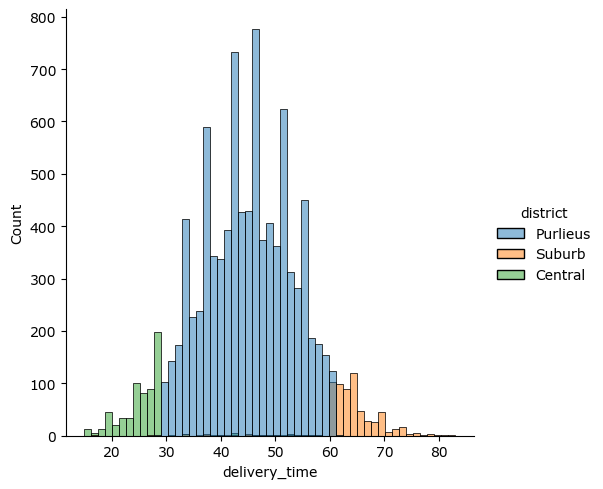

In [7]:
sns.displot(data=df_control, x='delivery_time', hue='district')

График распределения времени доставки в тестовой группе

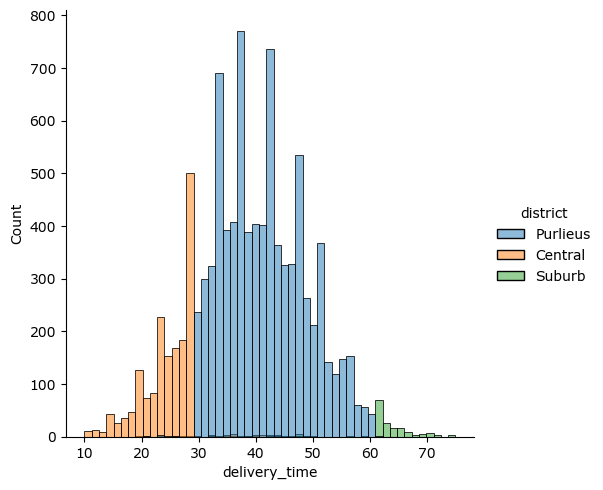

In [8]:
sns.displot(data=df_test, x='delivery_time', hue='district')

Количество наблюдений в тестовой и контрольной группах

In [9]:
df.groupby('experiment_group').order_id.count()

experiment_group
control    10092
test       10104
Name: order_id, dtype: int64

Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.
Перед применением критерия при проверке на нормальность (и для теста, и для контроля) произведем семплирование, так как на больших выборках мы можем получать неверные результаты.

In [10]:
control_sample = df[df['experiment_group'] == 'control']['delivery_time'].sample(1000, random_state=17)
test_sample = df[df['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17)

In [11]:
df.query('experiment_group == "control"').delivery_time.std()

9.990016960247171

In [12]:
df.query('experiment_group == "test"').delivery_time.std()

9.883308351129031

Стандартное отклонение времени доставки в тесте равно 9.88. Стандартное отклонение времени доставки в контроле равно 9.99.

Для проверки нормальности распределения используем Shapiro-Wilk test.

In [13]:
from scipy import stats
stats.shapiro(control_sample)


ShapiroResult(statistic=0.9974724054336548, pvalue=0.12408281117677689)

In [14]:
stats.shapiro(test_sample)

ShapiroResult(statistic=0.9975473880767822, pvalue=0.14001426100730896)

 Тест показывает, что значения в тестовой и контрольной группах распределены нормально.

In [16]:
df_control = df.query('experiment_group == "control"').delivery_time

In [17]:
df_test = df.query('experiment_group == "test"').delivery_time

Для сравнения средних в данных экспериментальных группах используем t-test Student's

In [18]:
stats.ttest_ind(df_test, df_control)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

Так как p-value < 0.05, мы можем говорить о статистически важных различиях времени доставки в экспериментальных группах.

In [20]:
((df_test.mean() - df_control.mean()) / df_control.mean()) * 100

-13.354653121660812

Среднее время доставки в тестовой группе по сравнению с контрольной уменьшилось в среднем на 13%. 

*Можем применить новый алгоритм на всех курьеров, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тестовой группе меньше, чем в контрольной.*